<a href="https://colab.research.google.com/github/vardanagarwal/SIH/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 45kB/s 
     |████████████████████████████████| 450kB 56.8MB/s 
     |████████████████████████████████| 3.8MB 65.4MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled goo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/data/first.zip', "r")
zf.extractall()
zf1 = zipfile.ZipFile('/content/drive/My Drive/data/second.zip', "r")
zf1.extractall()

In [0]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
SIZE = 224
N_CLASSES = 2

def parse_image_train(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "training", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "first", "second")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask_path = tf.strings.regex_replace(mask_path, r'[0-9]+', "0")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.rgb_to_grayscale(mask)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(1), mask)
    return {'image': image, 'segmentation_mask': mask}

def parse_image_validate(img_path: str) -> dict:
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    mask_path = tf.strings.regex_replace(img_path, "validation", "mask")
    mask_path = tf.strings.regex_replace(mask_path, "first", "second")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
    mask_path = tf.strings.regex_replace(mask_path, r'[0-9]+', "0")

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    #mask = tf.image.rgb_to_grayscale(mask)
    #mask = tf.where(mask == 255, np.dtype('uint8').type(1), mask)
    return {'image': image, 'segmentation_mask': mask}

train_imgs = tf.data.Dataset.list_files("first/training/*.jpg")
val_imgs = tf.data.Dataset.list_files("first/validation/*.jpg")
train_set = train_imgs.map(parse_image_train)
test_set = val_imgs.map(parse_image_validate)
dataset = {"train": train_set, "test": test_set}

def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (SIZE, SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (SIZE, SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

train_imgs = glob("first/training/*.jpg")
TRAIN_LENGTH = len(train_imgs)

BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

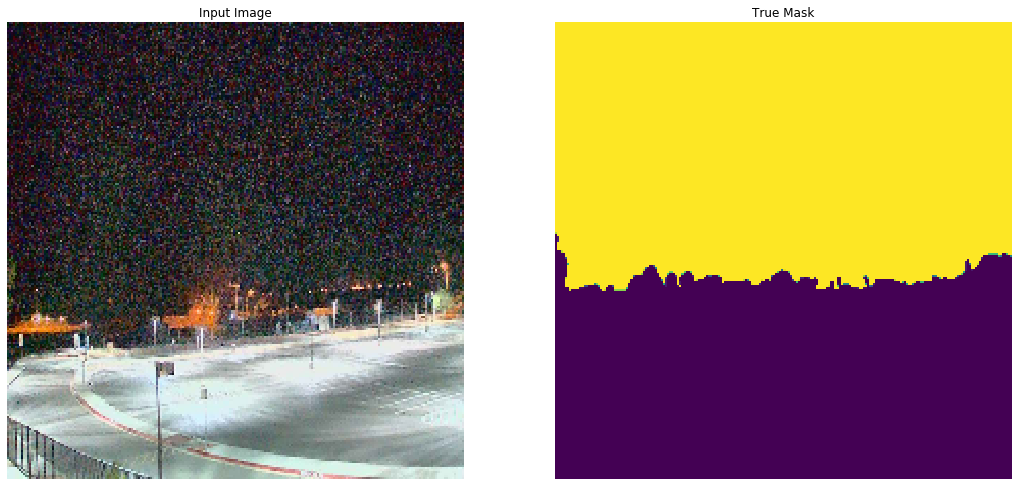

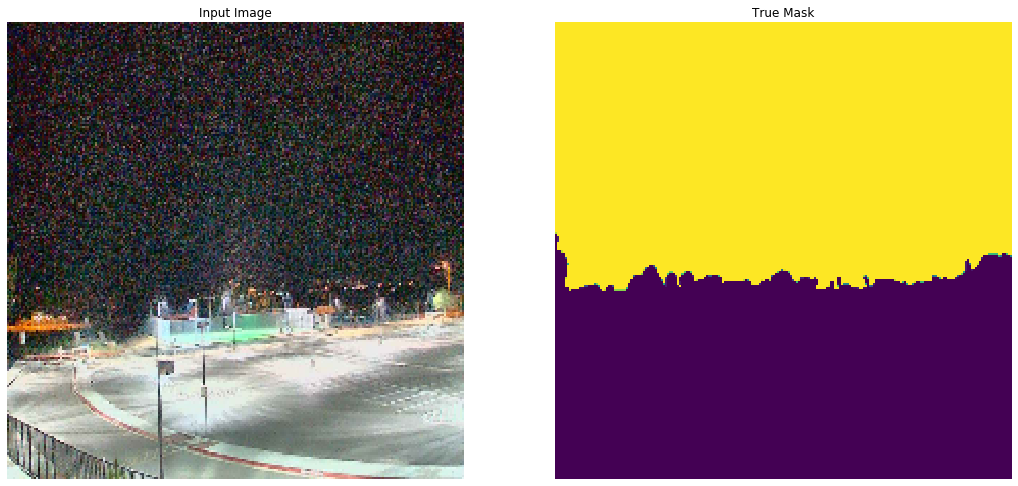

In [6]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(2):
    sample_image, sample_mask = image, mask
    display_sample([sample_image, sample_mask])

9412608/9406464 [==============================] - 1s 0us/step


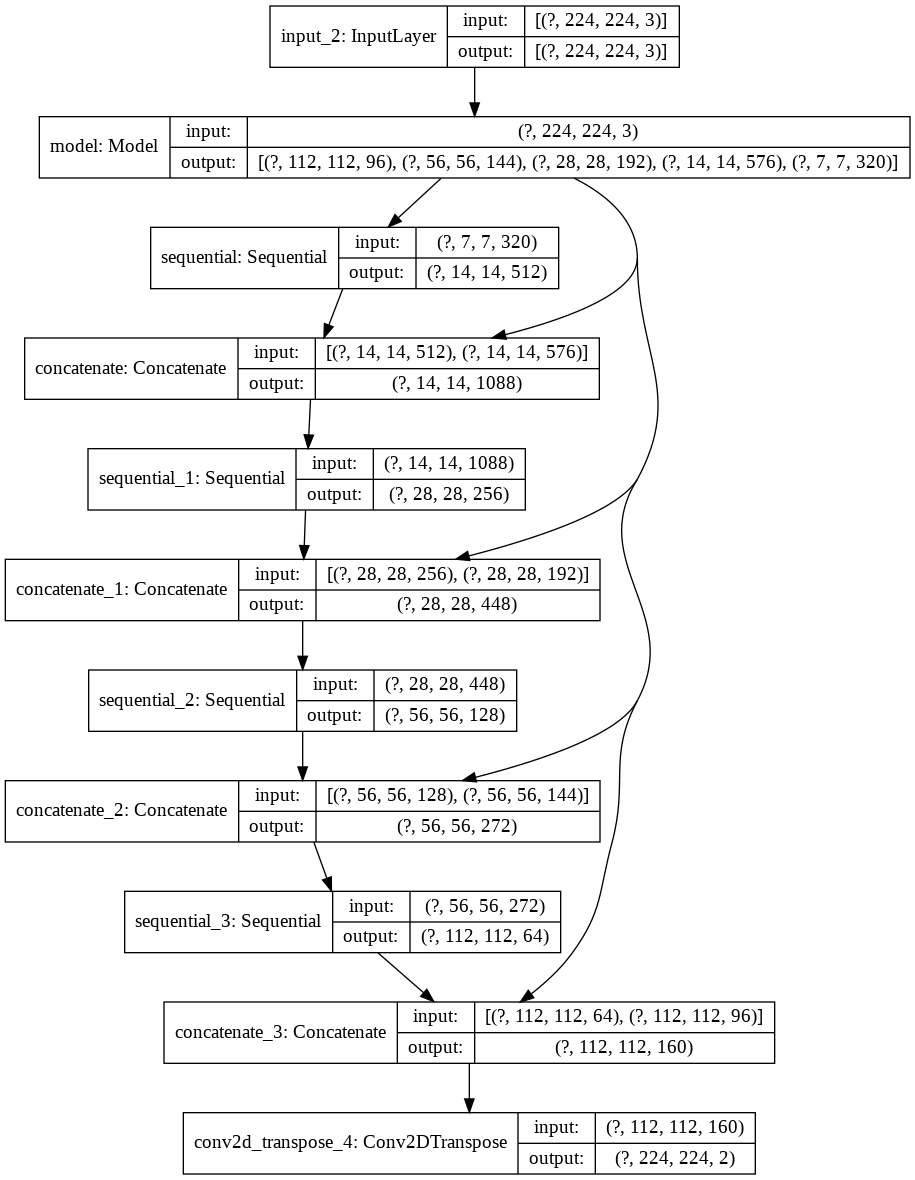

In [7]:
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

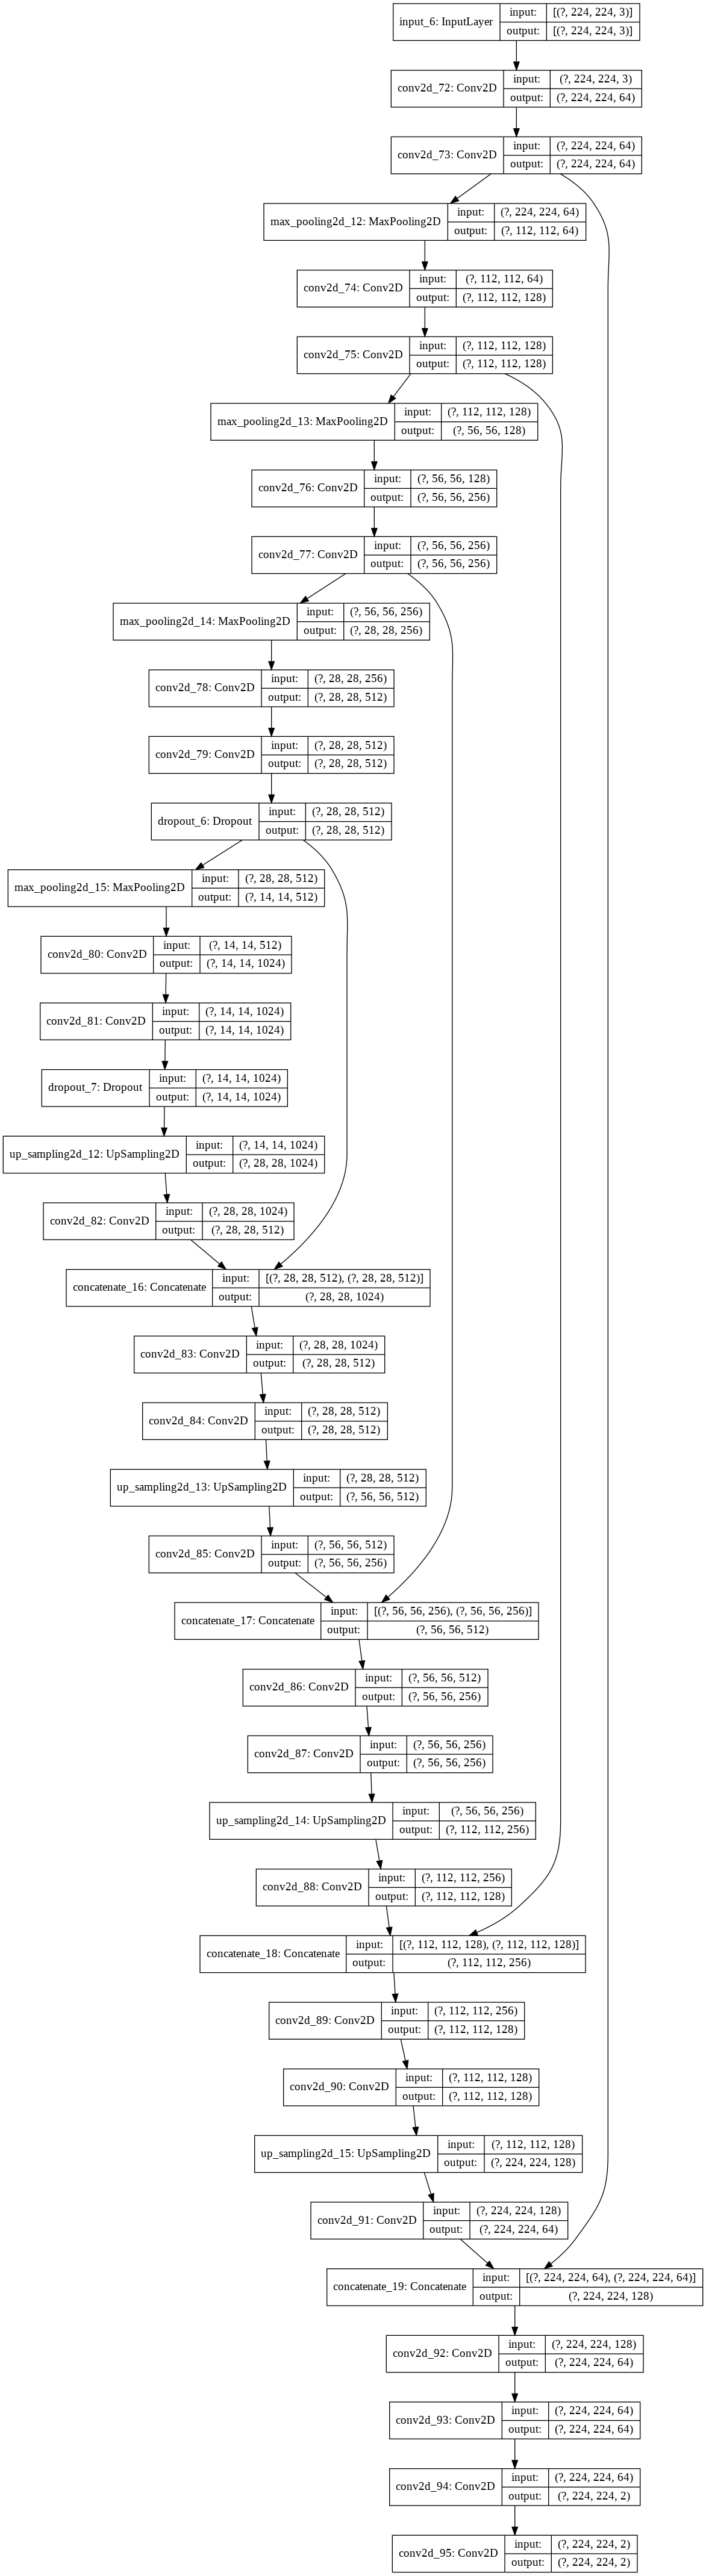

In [13]:
# def unet(pretrained_weights = None,input_size = (224,224,3)):
#     inputs = tf.keras.Input(input_size)
#     conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = tf.keras.layers.Dropout(0.5)(conv4)
#     pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = tf.keras.layers.Dropout(0.5)(conv5)

#     up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
#     merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
#     conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
#     merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
#     conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
#     merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
#     conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
#     merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
#     conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = tf.keras.layers.Conv2D(2, 1, activation = 'sigmoid')(conv9)

#     model = tf.keras.Model(inputs=inputs, outputs=conv10)

#     model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model
# model2 = unet()
# tf.keras.utils.plot_model(model2, show_shapes=True)
# #model.summary()

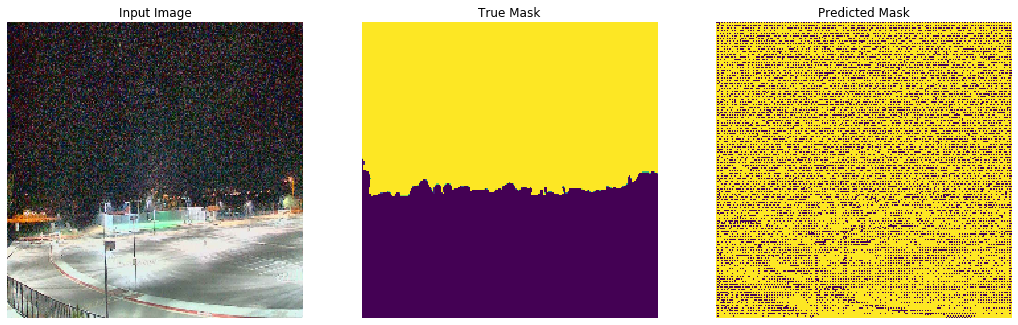

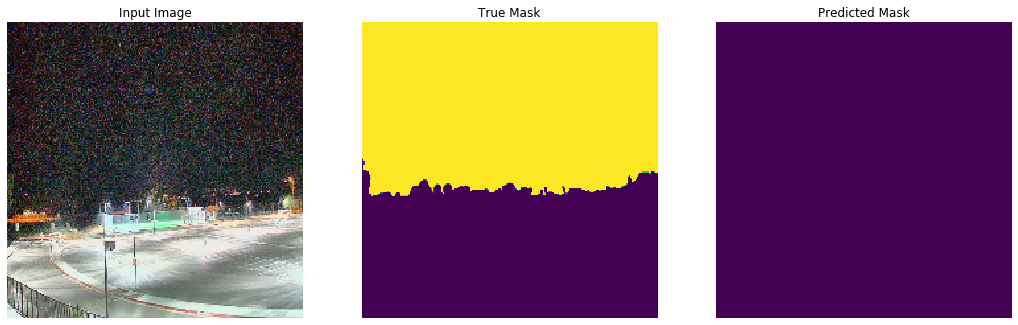

In [14]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model=model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_sample([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_sample([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()
# show_predictions(model2)

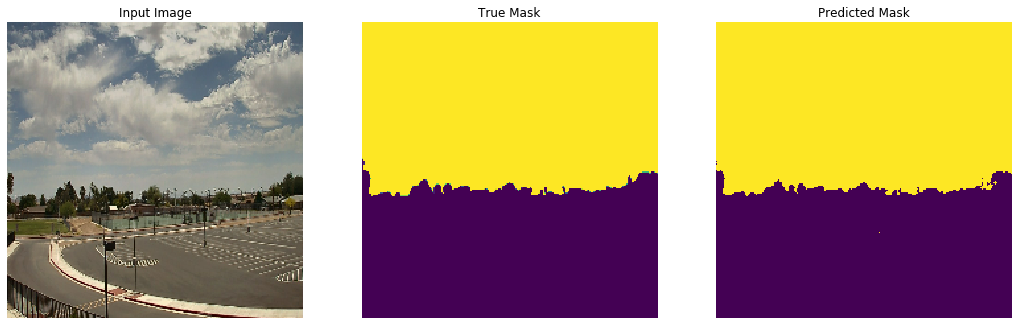


Sample Prediction after epoch 20

62/62 [==============================] - 15s 242ms/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.0160 - val_accuracy: 0.9830


In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20
VAL_SUBSPLITS = 2
VALIDATION_STEPS = 2000//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

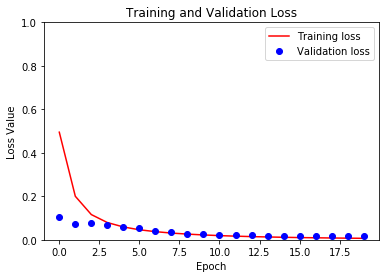

In [0]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

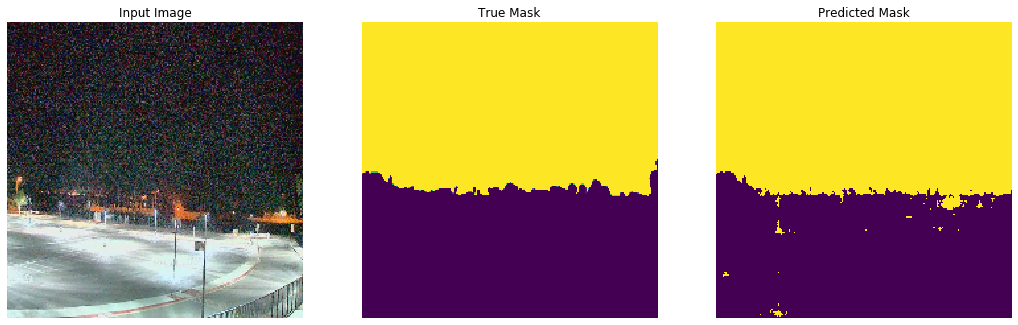

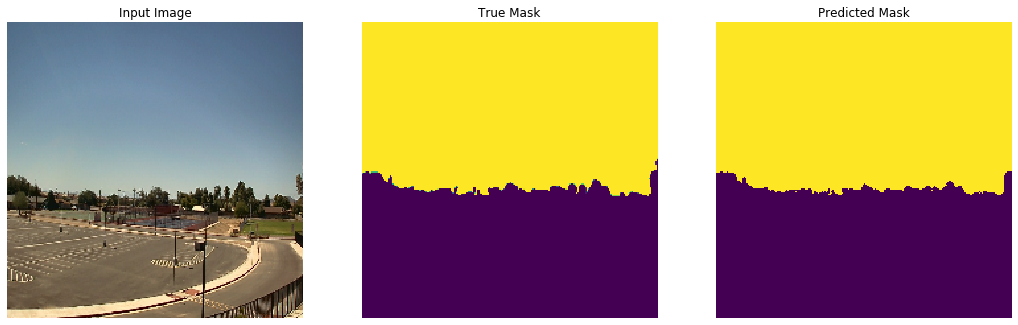

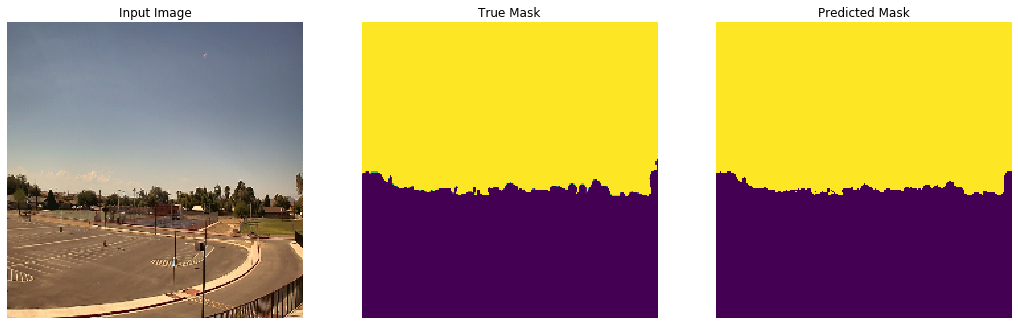

In [0]:
show_predictions(test_dataset, 3)